# Visualization of CNN filter & layer

## Introduction

In this documents, we will directly check extracted features after training by visualizing filters in TensorFlow.  
We'll use a MNIST data and all training & test codes are referenced by [DeepLearningZeroToAll-lab-11-2-mnist_deep_cnn](https://github.com/hunkim/DeepLearningZeroToAll/blob/master/lab-11-2-mnist_deep_cnn.py).

### Load MNIST data

In [1]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

tf.set_random_seed(777)  # reproducibility
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
mnist.train.images.shape

(55000, 784)

In [3]:
# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

### Define Model

In [4]:
# dropout (keep_prob) rate  0.7~0.5 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

# input place holders
X = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])   # img 28x28x1 (black/white)
Y = tf.placeholder(tf.float32, [None, 10])

# L1 ImgIn shape=(?, 28, 28, 1)
W1 = tf.Variable(tf.random_normal([7, 7, 1, 32], stddev=0.01))
#    Conv     -> (?, 28, 28, 32)
#    Pool     -> (?, 14, 14, 32)
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1],
                    strides=[1, 2, 2, 1], padding='SAME')
#L1 = tf.nn.dropout(L1, keep_prob=keep_prob)
'''
Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("dropout/mul:0", shape=(?, 14, 14, 32), dtype=float32)
'''

# L2 ImgIn shape=(?, 14, 14, 32)
W2 = tf.Variable(tf.random_normal([7, 7, 32, 64], stddev=0.01))
#    Conv      ->(?, 14, 14, 64)
#    Pool      ->(?, 7, 7, 64)
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],
                    strides=[1, 2, 2, 1], padding='SAME')
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)
'''
Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("dropout_1/mul:0", shape=(?, 7, 7, 64), dtype=float32)
'''

# L3 ImgIn shape=(?, 7, 7, 64)
W3 = tf.Variable(tf.random_normal([7, 7, 64, 128], stddev=0.01))
#    Conv      ->(?, 7, 7, 128)
#    Pool      ->(?, 4, 4, 128)
#    Reshape   ->(?, 4 * 4 * 128) # Flatten them for FC
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
L3 = tf.nn.relu(L3)
L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[
                    1, 2, 2, 1], padding='SAME')
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)
L3_flat = tf.reshape(L3, [-1, 128 * 4 * 4])
'''
Tensor("Conv2D_2:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("Relu_2:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("MaxPool_2:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("dropout_2/mul:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 2048), dtype=float32)
'''

# L4 FC 4x4x128 inputs -> 625 outputs
W4 = tf.get_variable("W4", shape=[128 * 4 * 4, 625],
                     initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([625]))
L4 = tf.nn.relu(tf.matmul(L3_flat, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)
'''
Tensor("Relu_3:0", shape=(?, 625), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 625), dtype=float32)
'''

# L5 Final FC 625 inputs -> 10 outputs
W5 = tf.get_variable("W5", shape=[625, 10],
                     initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([10]))
logits = tf.matmul(L4, W5) + b5
'''
Tensor("add_1:0", shape=(?, 10), dtype=float32)
'''

# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [5]:
# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### train model

In [6]:
# train my model
print('Learning started. It takes some time.')

for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.7}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

Learning started. It takes some time.
Epoch: 0001 cost = 0.260052685
Epoch: 0002 cost = 0.054952072
Epoch: 0003 cost = 0.041499506
Epoch: 0004 cost = 0.033821384
Epoch: 0005 cost = 0.029836067
Epoch: 0006 cost = 0.025557104
Epoch: 0007 cost = 0.023349122
Epoch: 0008 cost = 0.019528870
Epoch: 0009 cost = 0.019756447
Epoch: 0010 cost = 0.016211779
Epoch: 0011 cost = 0.017858094
Epoch: 0012 cost = 0.017441621
Epoch: 0013 cost = 0.015837867
Epoch: 0014 cost = 0.016353214
Epoch: 0015 cost = 0.012903986
Learning Finished!


### Test model

In [7]:
# Test model and check accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={
      X: mnist.test.images, Y: mnist.test.labels, keep_prob: 1}))

Accuracy: 0.9925


## Visualization(filter, layer)

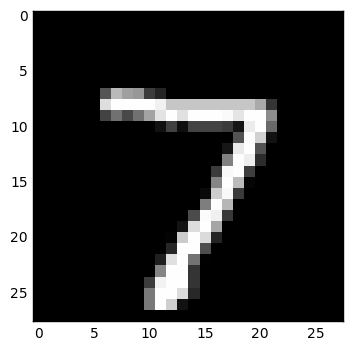

In [8]:
import numpy as np
img = mnist.test.images[0].reshape(28,28)
plt.imshow(img, interpolation='nearest', cmap='gray')

In [9]:
def visualize_filter(weights, channel=0):

    weight = sess.run(weights)
    depth = weight.shape[3]
    
    plt.figure(figsize=(8, 8))
    for i in range(depth):
        plt.subplot(8, 8, i+1)
        feature = weight[:, :, channel, i]
        plt.imshow(feature, interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.show()

In [10]:
def visualize_layer(layer, image):

    feed_dict = {X: np.reshape(image,[1,784]), keep_prob:1.0}
    output = sess.run(layer, feed_dict=feed_dict)
    depth = layer.shape[3]

    plt.figure(figsize=(8, 8))
    for i in range(depth):
        plt.subplot(8, 8, i+1)
        activated = output[0, :, :, i]
        plt.imshow(activated, interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.show()

Visualization of features in layer 1


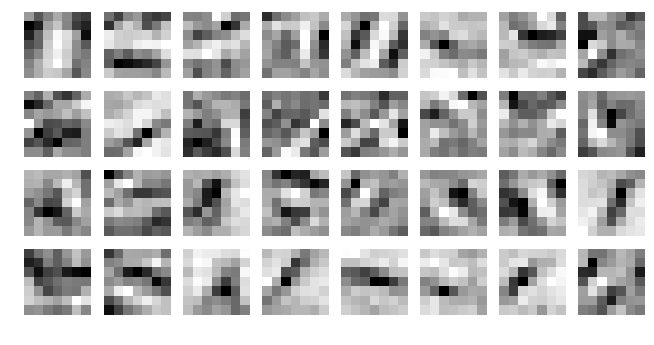

In [12]:
print("Visualization of features in layer 1")

visualize_filter(weights=W1)

Visualization of convolutional network activation in layer 1


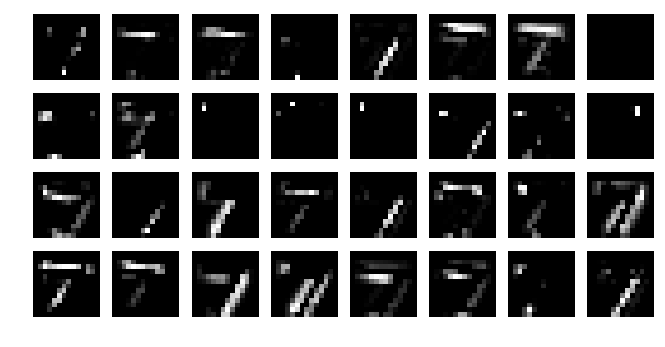

In [13]:
print("Visualization of convolutional network activation in layer 1")
    
visualize_layer(layer=L1, image=img)